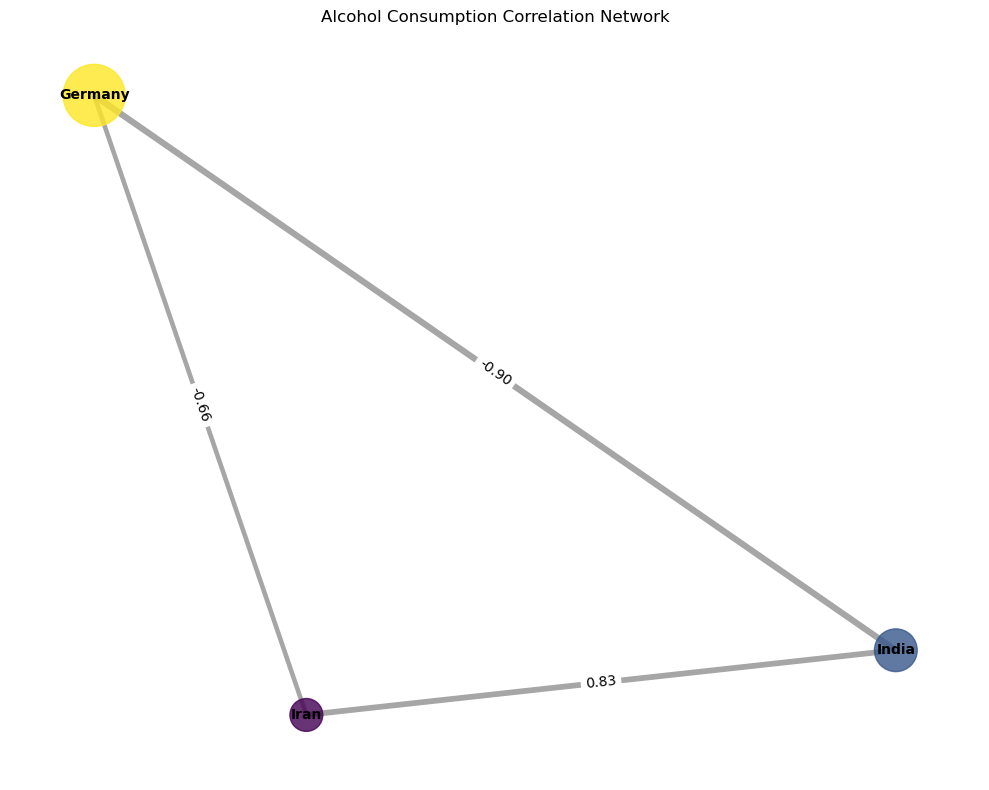


This network graph compares alcohol consumption trends (in liters per year) for Iran, India, and Germany
from 2000 onward. Nodes represent countries and their size reflects average alcohol consumption.
Edges represent correlation in consumption patterns between countries. Thicker edges mean stronger correlation.



In [9]:
# Alcohol Consumption Network Graph (Dynamic)

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from itertools import combinations

# Load data from local CSV file
# Replace with your actual path if needed
df = pd.read_csv('/home/mrh/alcohol.csv')

# Filter the desired series: Total alcohol consumption per capita in liters
series_name = "Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)"
target_countries = ['Iran', 'India', 'Germany']
filtered_df = df[(df['Country'].isin(target_countries)) & (df['Series Name'] == series_name)]

# Reshape data to long format (year-wise alcohol consumption per country)
melted = filtered_df.melt(
    id_vars=['Country'],
    value_vars=[col for col in df.columns if '[YR' in col],
    var_name='Year',
    value_name='Alcohol Consumption'
)

# Clean year column
melted['Year'] = melted['Year'].str.extract(r'(\d{4})').astype(int)

# Rename for clarity
melted.rename(columns={'Country': 'country', 'Year': 'year', 'Alcohol Consumption': 'consumption'}, inplace=True)

# Pivot to wide format: rows are years, columns are countries, values are consumption (liters)
pivot = melted.pivot(index='year', columns='country', values='consumption')

# Compute Pearson correlation between countries based on their annual alcohol consumption patterns
corr = pivot.corr()

# Build a correlation network graph
G = nx.Graph()
means = pivot.mean()  # average alcohol consumption per country (liters/year)

# Add nodes with average consumption as an attribute
for country, avg in means.items():
    G.add_node(country, mean_consumption=avg)

# Add edges for countries with moderate-to-strong correlation
threshold = 0.3  # Correlation threshold for visualizing relationships
for a, b in combinations(corr.columns, 2):
    weight = corr.loc[a, b]
    if abs(weight) >= threshold:
        G.add_edge(a, b, weight=weight)

# Static visualization of the network
pos = nx.spring_layout(G, seed=42)
node_sizes = [500 + (G.nodes[n]['mean_consumption'] / means.max()) * 1500 for n in G.nodes()]
node_colors = [G.nodes[n]['mean_consumption'] for n in G.nodes()]
edge_widths = [abs(G[u][v]['weight']) * 5 for u, v in G.edges()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='gray', alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
edge_labels = { (u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True) }
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Alcohol Consumption Correlation Network')
plt.axis('off')
plt.tight_layout()
plt.show()

# Interactive Plot with Plotly
# Each node size = average alcohol consumption (liters)
# Edge thickness = strength of correlation between countries' trends
graph_explanation = """
This network graph compares alcohol consumption trends (in liters per year) for Iran, India, and Germany
from 2000 onward. Nodes represent countries and their size reflects average alcohol consumption.
Edges represent correlation in consumption patterns between countries. Thicker edges mean stronger correlation.
"""
print(graph_explanation)

edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x,
    y=edge_y,
    mode='lines',
    line=dict(width=0.5, color='#888'),
    hoverinfo='none'
)

node_x, node_y, hover = [], [], []
for n in G.nodes():
    x, y = pos[n]
    node_x.append(x)
    node_y.append(y)
    hover.append(f"{n}<br>Avg consumption: {G.nodes[n]['mean_consumption']:.1f} liters/year")

node_trace = go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition='bottom center',
    hovertext=hover,
    hoverinfo='text',
    marker=dict(
        size=node_sizes,
        color=node_colors,
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Avg liters/year')
    )
)

fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title='Interactive Alcohol Consumption Network',
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False, visible=False),
    yaxis=dict(showgrid=False, zeroline=False, visible=False),
    margin=dict(l=20, r=20, t=50, b=20)
)
fig.show()